## Part 1

### Download the dataset


_In this section I'll do all the setup and dataframe tweaking_

In [399]:
import pandas as pd
import numpy as np
import io
import requests

__Read the data directly from the github URL into a dataframe:__

In [400]:
url = "https://raw.githubusercontent.com/zipfian/galvanize_mini_challenge_1/master/data/salary_take_home.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=0)
df.head()

,job_title,department,salary,Join Date
0,WATER RATE TAKER,WATER MGMNT,$87228.0,2000-09-27 00:00:00
1,POLICE OFFICER,POLICE,$75372.0,2000-08-04 00:00:00
2,POLICE OFFICER,POLICE,$75372.0,2000-01-20 00:00:00
3,CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,$80916.0,2000-04-27 00:00:00
4,CIVIL ENGINEER IV,WATER MGMNT,$99648.0,2000-02-11 00:00:00


__Remove spaces from column names:__

_ for ease of manipulation later_

In [401]:
df.rename(columns = {'Join Date':'join_date'}, inplace=True)
df.head()

,job_title,department,salary,join_date
0,WATER RATE TAKER,WATER MGMNT,$87228.0,2000-09-27 00:00:00
1,POLICE OFFICER,POLICE,$75372.0,2000-08-04 00:00:00
2,POLICE OFFICER,POLICE,$75372.0,2000-01-20 00:00:00
3,CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,$80916.0,2000-04-27 00:00:00
4,CIVIL ENGINEER IV,WATER MGMNT,$99648.0,2000-02-11 00:00:00


__Fix column datatypes:__
    
*salary' to float, 'join_date' to datetime*

In [402]:
df.salary = pd.to_numeric([entry.replace("$", "") for entry in df.salary])
df.join_date = pd.to_datetime(df.join_date)

__Confirm datatypes were updated as desired:__

In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32160 entries, 0 to 32159
Data columns (total 4 columns):
job_title     32160 non-null object
department    32160 non-null object
salary        32160 non-null float64
join_date     32160 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.2+ MB


_yep!_


## Part 2

### Compute the mean salary of the whole dataset

__Option 1:__

_take mean of the 'salary' column_

In [404]:
df.salary.mean()

75559.10887313307

__Option 2:__

_use the .describe method on the dataframe object, and the information shown includes the mean._

In [405]:
df.describe()

,salary
count,32160.000000
mean,75559.108873
std,23412.862198
min,0.960000
25%,69648.000000
50%,78012.000000
75%,87324.000000
max,260004.000000


> Mean salary, whole dataset: __$75,559__

## Part 3

### Compute the mean salary of Police Officers

__Filter DataFrame for job_titles equal to "POLICE OFFICER", and then calculate the mean of the salary column for that subset:__

In [406]:
df[df.eval('job_title == "POLICE OFFICER"')].salary.mean()

76560.34142206209

_but there are a lot of different job titles_

In [407]:
unique_titles = df.job_title.unique()
unique_titles, len(unique_titles)

(array(['WATER RATE TAKER', 'POLICE OFFICER', 'CHIEF CONTRACT EXPEDITER',
        ..., 'ANIMAL SHELTER MANAGER', 'PREPRESS TECHNICIAN',
        'MECHANICAL ENGINEER IV'], dtype=object), 1096)

_and I have a feeling that there may be some police officer jobs that aren't in this dataset exactly as "POLICE OFFICER"_

In [408]:
police_jobs = df[df.job_title.str.contains("POLICE OFFICER")].job_title.unique()
police_jobs, len(police_jobs)

(array(['POLICE OFFICER',
        'POLICE OFFICER (ASSIGNED AS EVIDENCE TECHNICIAN)',
        'POLICE OFFICER (ASSIGNED AS DETECTIVE)',
        'POLICE OFFICER/EXPLSV DETECT K9 HNDLR',
        'POLICE OFFICER / FLD TRNG OFFICER',
        'POLICE OFFICER (ASGND AS MARINE OFFICER)',
        'POLICE OFFICER (ASGND AS MOUNTED PATROL OFFICER)',
        'POLICE OFFICER (ASSIGNED AS CANINE HANDLER)',
        'POLICE OFFICER (PER ARBITRATION AWARD)',
        'POLICE OFFICER (ASSIGNED AS TRAFFIC SPECIALIST)',
        'POLICE OFFICER(ASGND AS LATENT PRINT EX)',
        'POLICE OFFICER (ASSIGNED AS SECURITY SPECIALIST)',
        'POLICE OFFICER(ASGND AS SUPVG LATENT PRINT EX)'], dtype=object), 13)

_my hunch is correct - in fact there are __13__ unique job titles that include the substring "POLICE OFFICER"!_

__So, filter the DataFrame for entries with a job title matching one of the titles from this array, and calculate the mean salary of that:__

In [409]:
df[df.job_title.isin(police_jobs)].salary.mean()

77891.0402482603

> Mean salary:
* "POLICE OFFICERS": 76,560
* All titles that include "POLICE OFFICER": 77,891

## Part 4

### Find the four job titles with the highest average salaries

__Group by job_title, find the mean salary, sort descending, and look only at top four entries:__

_save the result for use in later parts_

In [410]:
df_gb_job_title = df.groupby('job_title')
four_highest_sal_jts = df_gb_job_title.mean().sort_values('salary', ascending=False)[0:4]
four_highest_sal_jts

,salary
job_title,
SUPERINTENDENT OF POLICE,260004.0
MAYOR,216210.0
FIRE COMMISSIONER,202728.0
FIRST DEPUTY SUPERINTENDENT,188316.0


> Four job titles with highest average salaries:
* Superintendent of Police
* Mayor
* Fire Commissioner
* First Deputy Superintendent


## Part 5

### 95% confidence interval around the mean salary of the whole dataset

In [411]:
from scipy import stats

__Use scipy's stats module to calculate the mean, sigma, and sample size for the entire salary dataset:__

In [412]:
mean, sigma, N = df.salary.mean(), df.salary.std(ddof=1), len(df.salary)
mean, sigma, N

(75559.10887313307, 23412.862198213734, 32160)

__Plug these values into the interval calculator for a normal random distribution and a 95% confidence level:__

In [413]:
conf_interval_all_salary = stats.norm.interval(0.95, loc=mean, scale=sigma/(N**.5))
conf_interval_all_salary

(75303.224019418209, 75814.993726847926)

> There is a 95% chance that a randomly selected salary from the dataset will fall between __75,303__ and __75,815__.

## Part 6

### Boxplot showing the salaries for the top four Job Titles from Part 4

_get ready to display the plot_

In [414]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [415]:
#recall the result from part 4
four_highest_sal_jts

,salary
job_title,
SUPERINTENDENT OF POLICE,260004.0
MAYOR,216210.0
FIRE COMMISSIONER,202728.0
FIRST DEPUTY SUPERINTENDENT,188316.0


__As a boxplot:__

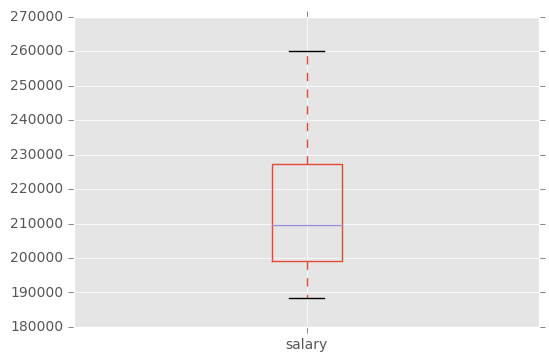

In [416]:
four_highest_sal_jts.plot.box()

__I need to make sure I'm getting all the salary data for those four job titles.__

_create objects needed to check the original dataframe for further entires of each job titles:_

In [417]:
table_four_highest_sal_jts = four_highest_sal_jts.transpose()
table_four_highest_sal_jtslst_four_highest_jts = list(table_four_highest_sal_jts)
lst_four_highest_jts

['SUPERINTENDENT OF POLICE',
 'MAYOR',
 'FIRE COMMISSIONER',
 'FIRST DEPUTY SUPERINTENDENT']

_Then search the original dataframe for each job title_:

In [418]:
[len(df[df.job_title == lst_four_highest_jts[i]]) for i in range(0,4)]

[1, 1, 1, 1]

_The above result tells me that each of the four highest salary job titles has only one entry in the entire table, so my initial box plot was actually complete._


_I had also planned a box plot of the salary spread for each individual job title, but again since there is only one each, it is not going to be very meaningful._

__For what it's worth, here it is:__

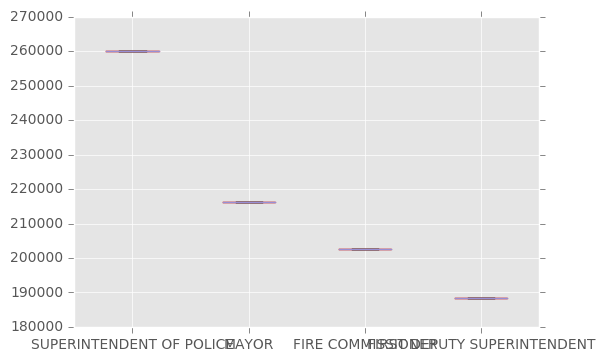

In [419]:
table_four_highest_sal_jts.plot.box()

__So to finish up the question, here is that first box plot again (with a title added):__

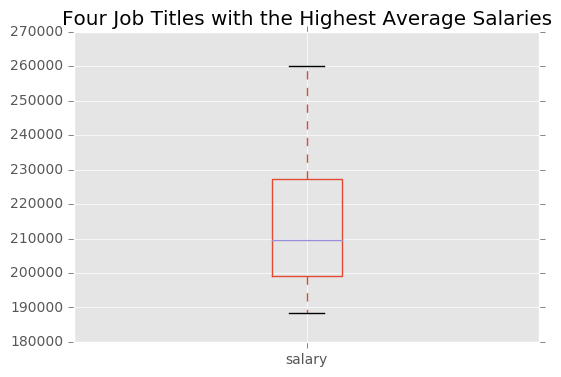

In [420]:
four_highest_sal_jts.plot.box(title="Four Job Titles with the Highest Average Salaries")